# Image Classification
In this project, I will classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. First, I preprocess the images, then train a convolutional neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded.  

## Get the Data
Run the following cell to download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

# Use Floyd's cifar-10 dataset if present
floyd_cifar10_location = '/input/cifar-10/python.tar.gz'
if isfile(floyd_cifar10_location):
    tar_gz_path = floyd_cifar10_location
else:
    tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

All files found!


## Explore the Data
The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck


Stats of batch 3:
Samples: 10000
Label Counts: {0: 994, 1: 1042, 2: 965, 3: 997, 4: 990, 5: 1029, 6: 978, 7: 1015, 8: 961, 9: 1029}
First 20 Labels: [8, 5, 0, 6, 9, 2, 8, 3, 6, 2, 7, 4, 6, 9, 0, 0, 7, 3, 7, 2]

Example of Image 4000:
Image - Min Value: 0 Max Value: 237
Image - Shape: (32, 32, 3)
Label - Label Id: 6 Name: frog


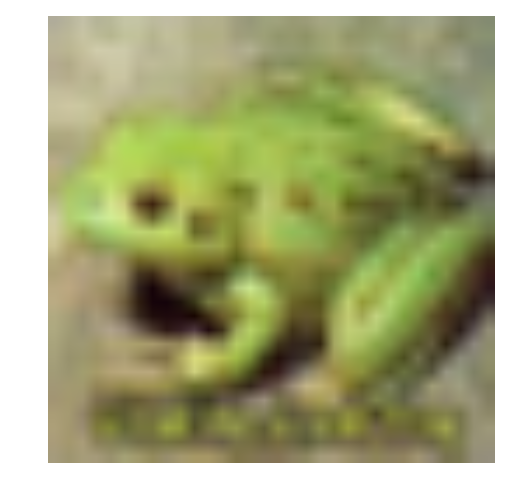

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 3
sample_id = 4000
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Preprocess Functions
### Normalize
The `normalize` function is implemented to take in image data, `x`, and return it as a normalized Numpy array. The values should be in the range of 0 to 1, inclusive.  The return object should be the same shape as `x`.

In [5]:
def normalize(x):

    # Normalize input data
    return np.array((x - np.min(x)) / (np.max(x) - np.min(x)))

tests.test_normalize(normalize)

Tests Passed


### One-hot encode
The `one_hot_encode` function encodes the labels and returns the list of labels as One-Hot encoded Numpy array.  The possible values for labels are 0 to 9.

In [6]:
def one_hot_encode(x):

    # Simple one-hot encode approach
    x_one_hot_encoded = np.zeros((len(x), 10))
    x_one_hot_encoded[np.arange(len(x)), x] = 1
    return x_one_hot_encoded

tests.test_one_hot_encode(one_hot_encode)

Tests Passed


## Preprocess all the data and save it
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [7]:
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# Check Point
Save preprocessed data to disk.

In [8]:
import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build the network
For the neural network, each layer will be implemented into a function.

### Input
The neural network needs to read the image data, one-hot encoded labels, and dropout keep probability. 
The follwing functions are implemented:

* Implement `neural_net_image_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `image_shape` with batch size set to `None`.
 * Name the TensorFlow placeholder "x" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implement `neural_net_label_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `n_classes` with batch size set to `None`.
 * Name the TensorFlow placeholder "y" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implement `neural_net_keep_prob_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder) for dropout keep probability.
 * Name the TensorFlow placeholder "keep_prob" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).

In [9]:
import tensorflow as tf

def neural_net_image_input(image_shape):

    # Placeholder input
    return tf.placeholder(tf.float32, shape=(None, image_shape[0], image_shape[1], image_shape[2]), name='x')


def neural_net_label_input(n_classes):

    # Placeholder classes
    return tf.placeholder(tf.float32, shape=[None, n_classes], name='y')


def neural_net_keep_prob_input():

    # Placeholder dropout
    return tf.placeholder(tf.float32, name='keep_prob')

tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


### Convolution and Max Pooling Layer
Convolution layers have a lot of success with images. Appying the `conv2d_maxpool` to apply convolution then max pooling:
* Create the weight and bias using `conv_ksize`, `conv_num_outputs` and the shape of `x_tensor`.
* Apply a convolution to `x_tensor` using weight and `conv_strides`.

* Add bias
* Add a nonlinear activation to the convolution.
* Apply Max Pooling using `pool_ksize` and `pool_strides`.

In [10]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    
    # Weights
    weights = tf.Variable(tf.random_normal([conv_ksize[0], conv_ksize[1], 
                                            x_tensor.get_shape().as_list()[-1], conv_num_outputs]))
    # Biases
    bias = tf.Variable(tf.zeros(conv_num_outputs))
    
    # Convolutional layer
    conv1 = tf.nn.conv2d(x_tensor, weights, strides=[1, conv_strides[0], conv_strides[1], 1], padding='SAME')
    conv1 = tf.nn.bias_add(conv1, bias)
    # Apply relu activation function
    conv1 = tf.nn.relu(conv1)
    # Max pooling
    conv1 = tf.nn.max_pool(conv1, ksize=[1, pool_ksize[0], pool_ksize[1], 1],\
                           strides=[1, pool_strides[0], pool_strides[1], 1], padding='SAME')
    
    return conv1 

tests.test_con_pool(conv2d_maxpool)

Tests Passed


### Flatten Layer
Implementation of the `flatten` function to change the dimension of `x_tensor` from a 4-D tensor to a 2-D tensor.  The output should be the shape (*Batch Size*, *Flattened Image Size*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer.

In [11]:
def flatten(x_tensor):

    # Flatten layer 
    return tf.contrib.layers.flatten(x_tensor)

tests.test_flatten(flatten)

Tests Passed


### Fully-Connected Layer
Implementation of the `fully_conn` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*).

In [12]:
def fully_conn(x_tensor, num_outputs):

    # Fully connected layer
    weights = tf.Variable(tf.truncated_normal([x_tensor.get_shape().as_list()[-1],num_outputs], stddev=0.1, dtype=tf.float32))
    bias = tf.Variable(tf.zeros(num_outputs))
    fc = tf.add(tf.matmul(x_tensor, weights), bias)
    fc = tf.nn.relu(fc)
    return fc

tests.test_fully_conn(fully_conn)

Tests Passed


### Output Layer
Implementation of the `output` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*).

In [13]:
def output(x_tensor, num_outputs):

    # Output layer
    weights = tf.Variable(tf.truncated_normal([x_tensor.get_shape().as_list()[-1],num_outputs], stddev=0.1, dtype=tf.float32))
    bias = tf.Variable(tf.zeros(num_outputs))
    out = tf.add(tf.matmul(x_tensor, weights), bias)
    return out

tests.test_output(output)

Tests Passed


### Create Convolutional Model
Implementation of the function `conv_net` to create a convolutional neural network model. The function takes in a batch of images, `x`, and outputs logits. 

* Apply Convolutions and Max Pool layers
* Apply a Flatten Layer
* Apply Fully Connected Layers
* Apply an Output Layer
* Return the output
* Apply [TensorFlow's Dropout](https://www.tensorflow.org/api_docs/python/tf/nn/dropout) to one or more layers in the model using `keep_prob`. 

In [14]:
def conv_net(x, keep_prob):

    # Convolutional neural network

    conv_num_outputs = 16
    conv_ksize = (2,2)
    conv_strides = (2,2)
    pool_ksize = (2,2)
    pool_strides = (2,2)
    conv1 = conv2d_maxpool(x, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    
    conv_num_outputs = 32
    conv_ksize = (2,2)
    conv_strides = (2,2)
    pool_ksize = (2,2)
    pool_strides = (2,2)    
    conv2 = conv2d_maxpool(conv1, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    
    conv_num_outputs = 64
    conv_ksize = (2,2)
    conv_strides = (2,2)
    pool_ksize = (2,2)
    pool_strides = (2,2)       
    conv3 = conv2d_maxpool(conv2, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
 
    x_flatten = flatten(conv1)
     
    fc1 = fully_conn(x_flatten, 256)
    fc1 = tf.nn.dropout(fc1, keep_prob)
    fc2 = fully_conn(fc1, 128)
    
    n_classes = 10
    out = output(fc2, n_classes)

    return out

##############################
## Build the Neural Network ##
##############################

# Reset the grapth to remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

Neural Network Built!


## Train the Neural Network
### Single Optimization
Implementation of the function `train_neural_network` to do a single optimization.  The optimization should use `optimizer` to optimize in `session` with a `feed_dict` of the following:
* `x` for image input
* `y` for labels
* `keep_prob` for keep probability for dropout

This function will be called for each batch, so `tf.global_variables_initializer()` has already been called.

In [15]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):

    # Optimizer
    return session.run(optimizer, feed_dict={x: feature_batch, y: label_batch, keep_prob: keep_probability})

tests.test_train_nn(train_neural_network)

Tests Passed


### Show Stats
Implementation of the function `print_stats` to print loss and validation accuracy.

In [16]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):

    # Print stats
    loss = session.run(cost, feed_dict = {x: feature_batch, y: label_batch, keep_prob: 1.0})
    valid_acc = session.run(accuracy, feed_dict = {x: valid_features, y: valid_labels, keep_prob: 1.0})

    print('Loss {:>2}, Valid Acc. {}:  '.format(loss, valid_acc))
    

### Hyperparameters

In [17]:
epochs = 30
batch_size = 128
keep_probability = 0.5

### Train on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, let's use a single batch. This should save time while you iterate on the model to get a better accuracy.  Once the final validation accuracy is 50% or greater, the model is run with all the data in the next section.

In [18]:
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  Loss 2.165860414505005, Valid Acc. 0.24279998242855072:  
Epoch  2, CIFAR-10 Batch 1:  Loss 2.0686042308807373, Valid Acc. 0.30799996852874756:  
Epoch  3, CIFAR-10 Batch 1:  Loss 2.019928216934204, Valid Acc. 0.34859997034072876:  
Epoch  4, CIFAR-10 Batch 1:  Loss 1.9083621501922607, Valid Acc. 0.3831999897956848:  
Epoch  5, CIFAR-10 Batch 1:  Loss 1.865294337272644, Valid Acc. 0.3959999680519104:  
Epoch  6, CIFAR-10 Batch 1:  Loss 1.7420411109924316, Valid Acc. 0.40859997272491455:  
Epoch  7, CIFAR-10 Batch 1:  Loss 1.713998794555664, Valid Acc. 0.41019997000694275:  
Epoch  8, CIFAR-10 Batch 1:  Loss 1.6427884101867676, Valid Acc. 0.42659997940063477:  
Epoch  9, CIFAR-10 Batch 1:  Loss 1.58695650100708, Valid Acc. 0.4479999840259552:  
Epoch 10, CIFAR-10 Batch 1:  Loss 1.5086653232574463, Valid Acc. 0.4469999670982361:  
Epoch 11, CIFAR-10 Batch 1:  Loss 1.4785422086715698, Valid Acc. 0.4559999704360962:  


##### Fully Train the Model
Now, I run the model on all batches.

In [19]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss 2.170488119125366, Valid Acc. 0.2629999816417694:  
Epoch  1, CIFAR-10 Batch 2:  Loss 1.9763336181640625, Valid Acc. 0.3153999447822571:  
Epoch  1, CIFAR-10 Batch 3:  Loss 1.6808801889419556, Valid Acc. 0.3497999608516693:  
Epoch  1, CIFAR-10 Batch 4:  Loss 1.7663373947143555, Valid Acc. 0.37999996542930603:  
Epoch  1, CIFAR-10 Batch 5:  Loss 1.7613376379013062, Valid Acc. 0.39660000801086426:  
Epoch  2, CIFAR-10 Batch 1:  Loss 1.922776699066162, Valid Acc. 0.3957999646663666:  
Epoch  2, CIFAR-10 Batch 2:  Loss 1.549108624458313, Valid Acc. 0.4103999733924866:  
Epoch  2, CIFAR-10 Batch 3:  Loss 1.379365086555481, Valid Acc. 0.44159996509552:  
Epoch  2, CIFAR-10 Batch 4:  Loss 1.5322048664093018, Valid Acc. 0.4567999243736267:  
Epoch  2, CIFAR-10 Batch 5:  Loss 1.6108527183532715, Valid Acc. 0.44679996371269226:  
Epoch  3, CIFAR-10 Batch 1:  Loss 1.6191112995147705, Valid Acc. 0.4737999439239502:  
Epoch  3, CIFAR-10 Batch 2:  Loss 

Epoch 19, CIFAR-10 Batch 5:  Loss 0.4632836580276489, Valid Acc. 0.6049998998641968:  
Epoch 20, CIFAR-10 Batch 1:  Loss 0.6457626223564148, Valid Acc. 0.6047998666763306:  
Epoch 20, CIFAR-10 Batch 2:  Loss 0.4538770318031311, Valid Acc. 0.6043999195098877:  
Epoch 20, CIFAR-10 Batch 3:  Loss 0.42120954394340515, Valid Acc. 0.5997999906539917:  
Epoch 20, CIFAR-10 Batch 4:  Loss 0.5074083805084229, Valid Acc. 0.6017998456954956:  
Epoch 20, CIFAR-10 Batch 5:  Loss 0.4499964714050293, Valid Acc. 0.6017999053001404:  
Epoch 21, CIFAR-10 Batch 1:  Loss 0.5813733339309692, Valid Acc. 0.6059998869895935:  
Epoch 21, CIFAR-10 Batch 2:  Loss 0.44805651903152466, Valid Acc. 0.6033998727798462:  
Epoch 21, CIFAR-10 Batch 3:  Loss 0.3692498207092285, Valid Acc. 0.6041998863220215:  
Epoch 21, CIFAR-10 Batch 4:  Loss 0.4738156199455261, Valid Acc. 0.605199933052063:  
Epoch 21, CIFAR-10 Batch 5:  Loss 0.4080844521522522, Valid Acc. 0.6075999140739441:  
Epoch 22, CIFAR-10 Batch 1:  Loss 0.586717

# Checkpoint
The model has been saved to disk.
## Test Model
Test the model against the test dataset.  This will be your final accuracy. The accuracy should be greater than 50%.

Testing Accuracy: 0.6250988924050633



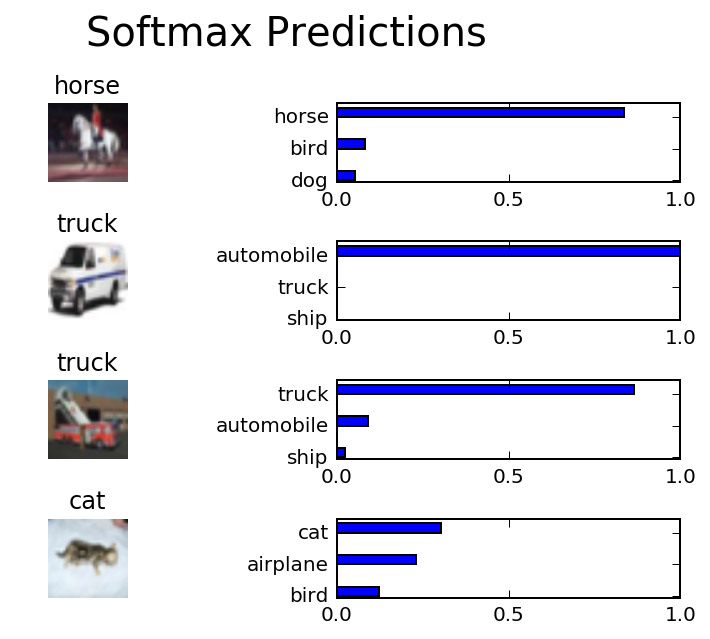

In [20]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():

    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()

### Discussion: Why 50-70% Accuracy?
You might be wondering why you can't get an accuracy any higher. First things first, 50% isn't bad for a simple CNN.  Pure guessing would get you 10% accuracy. However, you might notice people are getting scores [well above 70%](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130).
## Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook.  Save the notebook file as "dlnd_image_classification.ipynb" and save it as a HTML file under "File" -> "Download as".  Include the "helper.py" and "problem_unittests.py" files in your submission.